In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from numba import jit, prange, jitclass
from numba.types import int32
from time import time
from pprint import pprint
from copy import deepcopy as copy


%matplotlib inline

## Read data files

**Note** We are keeping only the 50 states. DC not included. Self loops not included

In [2]:
def read_US_states(fname):
    states_abb_dict = {}
    states_abb_rev_dict = {}
    states_abb_ord_list = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip().split(",")
            name = line[0]
            abbr = line[1]
            states_abb_dict[name] = (abbr, len(states_abb_ord_list))
            states_abb_rev_dict[abbr] = name
            states_abb_ord_list.append(abbr)
    
    return states_abb_dict, states_abb_rev_dict, states_abb_ord_list

def read_travel_network(fname, states_abb_dict, states_abb_rev_dict, normalization=1000):
    num_states = 50

    adjacency_list = {}
    A = np.zeros((num_states, num_states))

    for abb in states_abb_rev_dict:
        adjacency_list[abb] = []

    with open(fname, "r") as f:
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            line = line.strip().split(",")
            orig = line[0]
            dest = line[1]
            weight = float(line[2])*10 / normalization
            if orig == dest:
                continue
            try:
                orig_abb, orig_idx = states_abb_dict[orig]
                dest_abb, dest_idx = states_abb_dict[dest]
                adjacency_list[orig_abb].append((dest_abb, weight))
                A[orig_idx][dest_idx] = weight
            except KeyError:
                pass
    
    return adjacency_list, A

def read_deaths_data(fname):
    df = pd.read_csv(fname)
    sum_df_d = df.groupby(['State', 'Year', 'Quarter'])[['DeathsFromPneumoniaAndInfluenza']].sum().T.to_dict()
    deaths_dict = {}
    for key, deaths in sum_df_d.items():
        state, year, quarter = key
        if state not in deaths_dict:
            deaths_dict[state] = {}
        if year not in deaths_dict[state]:
            deaths_dict[state][year] = {}
        deaths_dict[state][year][quarter] = deaths["DeathsFromPneumoniaAndInfluenza"]
    return deaths_dict

def read_deaths_data_monthly(fname):
    df = pd.read_csv(fname)
    sum_df_d = df.groupby(['State', 'Year', 'Month'])[['DeathsFromPneumoniaAndInfluenza']].sum().T.to_dict()
    deaths_dict = {}
    for key, deaths in sum_df_d.items():
        state, year, quarter = key
        if state not in deaths_dict:
            deaths_dict[state] = {}
        if year not in deaths_dict[state]:
            deaths_dict[state][year] = {}
        deaths_dict[state][year][quarter] = deaths["DeathsFromPneumoniaAndInfluenza"]
    return deaths_dict

def read_population_dict(fname):
    population_dict = {}
    with open(fname, "r") as f:
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            line = line.strip().split(",")
            state = line[1]
            population_dict[state] = {}
            year = 2009
            for idx, pop in enumerate(line[2:]):
                population_dict[state][year + idx] = int(pop)
    return population_dict

In [3]:
class State:
    def __init__(self, pop):
        self.num_total = pop
        self.num_infected = 0
        self.num_deceased = 0
    
    def infected_fraction(self):
        return self.num_infected / self.num_total

In [4]:
def travel_and_infect_kernel(A, states, p_transfer, verbose=False):
    N = A.shape[0]
    new_states = copy(states)
    
    for i in range(N):
        
        # Let X be number of successful infections.
        # X is Binomial(n, p_transfer) where n is number of travelers.
        # We want X >= 1 for each person at destination i.e.,
        # at least one successful infection for each person at destination.
        # So, calculate p' = P(X >= 1) = 1 - P(X = 0) = 1 - (1-p_transfer)^n.
        # p' is the probability a person at destination gets infected.
        # This reduces problem to calculate a new r.v. Y.
        # Y is Binomial(m, p'), where m is the uninfected population of destination
        
        infected_fraction = states[i].infected_fraction()
        travel_pop_inf = A[i, :] * infected_fraction
        ccdf = 1 - (1 - p_transfer)**travel_pop_inf
        
        for j in range(N):
            if i == j:
                continue
            dest = states[j]
            new_states[j].num_infected += np.random.binomial(dest.num_total - dest.num_infected, ccdf[j])
        
    return new_states

def recover_kernel(states, SIR_params):
    for i, state in enumerate(states):
        x = np.random.multinomial(states[i].num_infected, SIR_params)
        recovered = x[0]
        dead = x[2]
        states[i].num_infected -= (dead + recovered)
        states[i].num_deceased += dead
    return states

def remove_deceased_kernel(states):
    num_deceased = []
    for i, state in enumerate(states):
        num_deceased.append(state.num_deceased)
        state.num_total = max(state.num_total - state.num_deceased, 0)
        state.num_deceased = 0
        states[i] = state
    return states, num_deceased
    
def inject_population_kernel(states, new_population):
    # new_population is somehow ordered
    for i, state in enumerate(states):
        current_pop = state.num_total
        nextgen_pop = new_population[state_id]
        extra_peeps = nextgen_pop - current_pop
        if extra_peeps > 0:
            state.num_total += extra_peeps
        elif extra_peeps < 0:
            # population actually decreased... remove infected and susceptible at same rate
            extra_peeps = -extra_peeps
            if extra_peeps // 2 >= state.num_infected:
                state.num_total = state.num_total - (extra_peeps - state.num_infected)
                state.num_infected = 0
            else:
                state.num_infected -= (extra_peeps - extra_peeps//2)
                state.num_total -= extra_peeps
        states[i] = state
    return states

def random_infection_kernel(states, p_inf):
    for i, state in enumerate(states):
        if state.num_total < state.num_infected:
            continue
        infected = np.random.binomial(state.num_total - state.num_infected, p_inf)
        state.num_infected += infected
        states[i] = state
    return states

In [5]:
data_dir = "../Data/Clean/"
deaths_fname = "deaths_NCHS_processed.csv"
population_fname = "population.csv"

states_abb_dict, states_abb_rev_dict, stats_abb_ord_list = read_US_states(data_dir + "states_abb.csv")
deaths_dict = read_deaths_data_monthly(data_dir + deaths_fname)
population_dict = read_population_dict(data_dir + population_fname)

quarter_to_month = {1:[1,2,3],
                    2:[4,5,6],
                    3:[7,8,9],
                    4:[10,11,12]
                   }


adj_list = {}
A = {}
A[2009] = {}
A[2009][4] = {}
for i in range(10,13):
    A[2009][4][i] = read_travel_network(data_dir + "2009_Q4.csv", states_abb_dict, states_abb_rev_dict)[1]

for year in range(2010, 2019):
    A[year] = {}
    for quarter in range(1, 5):
        A[year][quarter] = {}
        for month in quarter_to_month[quarter]:
            network_fname = str(year) + "_Q" + str(quarter) + ".csv"
            A[year][quarter][month] = read_travel_network(data_dir + network_fname, states_abb_dict, states_abb_rev_dict)[1]
A[2019] = {}
A[2019][1] = {}
for i in range(1,4):
    A[2019][1][i] = read_travel_network(data_dir + "2019_Q1.csv", states_abb_dict, states_abb_rev_dict)[1]

all_population = {}
years = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
for year in years:
    all_population[year] = []


for state,data in population_dict.items():
    for year, pop in data.items():
        all_population[year].append(pop)
        
A_dict = A

In [1]:
# deaths_dict

In [7]:
# Fix parameters of the model
p_inf = 0.1
p_transfer = 0.1
p_rec = 0.99
p_die = 7.540044190323758e-05
p_stay = 1 - p_rec - p_die
SIR = [p_rec, p_stay, p_die]

In [8]:
sim_time = time()

states = []
year_0 = 2009
for state_id in range(50):
    state = State(all_population[year_0][state_id])
    state.num_infected += np.random.binomial(state.num_total, p_inf)
    states.append(state)
    
# Propagate infection
num_deceased = {}

# For each year:
for year in years:
    iter_time = time()
    num_deceased[year] = {}
    # For each quarter:
    for quarter in range(1, 5):
        if year == 2009 and quarter != 4:
            continue
        if year == 2019 and quarter != 1:
            continue
        num_deceased[year][quarter] = {}
        for month in quarter_to_month[quarter]:
            # 1. travel and infect
            # 2. Recover
            # 3. Remove deceased and store it
            # 4. Randomly infect
            states = travel_and_infect_kernel(A_dict[year][quarter][month], states, p_transfer)
            states = recover_kernel(states, SIR)
            states, dead_peeps = remove_deceased_kernel(states)
            num_deceased[year][quarter][month] = dead_peeps
            states = random_infection_kernel(states, p_inf)
    
    # Inject population
    try:
        pop_vec = inject_population_kernel(states, all_population[year+1])
    except KeyError:
        # We are at the end of our data
        pass
    
    iter_time = time() - iter_time
    print("Elapsed time for {}: {:.3f} s".format(year, iter_time))

sim_time = time() - sim_time
print("Total elapsed time for simulation: {:.3f} s".format(sim_time))

Elapsed time for 2009: 0.029 s
Elapsed time for 2010: 0.122 s
Elapsed time for 2011: 0.125 s
Elapsed time for 2012: 0.122 s
Elapsed time for 2013: 0.126 s
Elapsed time for 2014: 0.118 s
Elapsed time for 2015: 0.123 s
Elapsed time for 2016: 0.120 s
Elapsed time for 2017: 0.122 s
Elapsed time for 2018: 0.121 s
Total elapsed time for simulation: 1.131 s


In [9]:
num_deceased = pd.DataFrame.from_records([[i, j, k] + num_deceased[i][j][k]
                                          for i in num_deceased
                                          for j in num_deceased[i]
                                          for k in num_deceased[i][j]])
num_deceased.to_csv('deceased_df_real_data_monthly.csv')


# Plot bar plots

In [10]:
state_abbr = ['AK', 'AL', 'AZ', 'AR', 'CA',
              'CO', 'CT', 'DE', 'FL', 'GA',
              'HI', 'ID', 'IL', 'IN', 'IA',
              'KS', 'KY', 'LA', 'ME', 'MD',
              'MA', 'MI', 'MN', 'MS', 'MO',
              'MT', 'NE', 'NV', 'NH', 'NJ',
              'NM', 'NY', 'NC', 'ND', 'OH',
              'OK', 'OR', 'PA', 'RI', 'SC',
              'SD', 'TN', 'TX', 'UT', 'VT',
              'VA', 'WA', 'WV', 'WI', 'WY'
             ]

In [11]:
deaths_true = pd.read_csv('../Data/Clean/deaths_NCHS_processed.csv')
deaths_monthly = pd.read_csv('deceased_df_real_data_monthly.csv', names=['unnamed', 'Year', 'Quarter', 'Month']+state_abbr)[1:]
deaths_monthly.drop('unnamed', axis=1, inplace=True)


In [12]:
grouped = deaths_true.groupby(['Year', 'Month']).sum()

In [13]:
grouped

Unnamed: 0  DeathsFromPneumoniaAndInfluenza   Week  Quarter
Year Month                                                             
2009 10        3273295                          19803.0  10920     1040
     11        2619608                          15862.0   9672      832
     12        2620472                          16414.0  10504      832
2010 1         3276805                          21530.0    780      260
     2         2622416                          17116.0   1560      208
     3         2623280                          16792.0   2392      208
     4         2624144                          14930.0   3224      416
     5         3281395                          16929.0   5200      520
     6         2626088                          12775.0   5096      416
     7         3283825                          15423.0   7540      780
     8         2628032                          11892.0   6968      624
     9         2628896                          12686.0   7800      624
     10        3287335                          17160.0  10920     1040
     11        2630840                          14639.0   9672      832
     12        2631704                          16581.0  10504      832
2011 1         3290845                          24040.0    780      260
     2         2633648                          20192.0   1560      208
     3         2634512                          18203.0   2392      208
     4         3294355                          19527.0   4160      520
     5         2636456                          14366.0   4264      416
     6         2637320                          13477.0   5096      416
     7         3297865                          15521.0   7540      780
     8         2639264                          12143.0   6968      624
     9         2640128                          12404.0   7800      624
     10        3301375                          16877.0  10920     1040
     11        2642072                          14510.0   9672      832
     12        2642936                          15415.0  10504      832
2012 1         3304885                          21128.0    780      260
     2         2644880                          16684.0   1560      208
     3         3307315                          20600.0   3120      312
...                ...                              ...    ...      ...
2016 10        3371845                          15692.0  10920     1040
     11        2698448                          13255.0   9672      832
     12        2699312                          15567.0  10504      832
2017 1         3375355                          24310.0    780      260
     2         2701256                          19598.0   1560      208
     3         2702120                          17800.0   2392      208
     4         3378865                          18640.0   4160      520
     5         2704064                          12677.0   4264      416
     6         2704928                          12192.0   5096      416
     7         3382375                          14211.0   7540      780
     8         2706872                          10911.0   6968      624
     9         3384805                          14760.0   9880      832
     10        2708816                          12755.0   8840      832
     11        2709680                          13413.0   9672      832
     12        2710544                          16996.0  10504      832
2018 1         2711408                          27027.0    520      208
     2         2712272                          23197.0   1352      208
     3         3391555                          21815.0   2860      260
     4         2714216                          14878.0   3224      416
     5         2715080                          12338.0   4056      416
     6         3395065                          14525.0   6240      520
     7         2717024                          10974.0   5928      624
     8         2717888                          1066

In [14]:
deaths_monthly['total_deaths'] = deaths_monthly.drop(['Year', 'Month'], axis=1).sum(axis=1)

In [15]:
deaths_monthly

,Year,Quarter,Month,AK,AL,AZ,AR,CA,CO,CT,...,TN,TX,UT,VT,VA,WA,WV,WI,WY,total_deaths
1,2009,4,10,1401,84,8453,671,58783,8228,1230,...,6216,49565,2355,44,10060,6436,120,3563,37,337262
2,2009,4,11,2423,139,8955,1194,52330,7883,2081,...,7680,40535,3049,116,10698,7622,273,5201,64,347121
3,2009,4,12,2408,148,9371,1164,54523,8300,2059,...,7841,44391,3030,142,10826,7659,275,5136,60,359469
4,2010,1,1,28,4,227,9,1582,265,49,...,191,1276,103,34,348,210,4,175,7,10395
5,2010,1,2,409,63,3127,180,16251,3207,415,...,1965,15839,1121,69,3215,1931,34,1124,42,107313
6,2010,1,3,597,110,3172,350,14955,3031,624,...,2352,13473,1280,94,3316,2207,109,1582,93,108363
7,2010,2,4,665,184,3314,366,16271,3405,732,...,2547,14810,1345,110,3779,2567,126,1729,64,120061
8,2010,2,5,710,210,3428,410,16240,3354,729,...,2557,14492,1341,106,3749,2557,138,1707,78,119717
9,2010,2,6,724,195,3387,390,16197,3514,705,...,2653,14844,1311,115,3826,2628,130,1728,66,120036
10,2010,3,7,732,233,3261,424,16464,3465,770,...,2623,14673,1412,130,3770,2695,146,1667,106,121108


Text(0.5, 1.0, 'Total number of deaths per month')

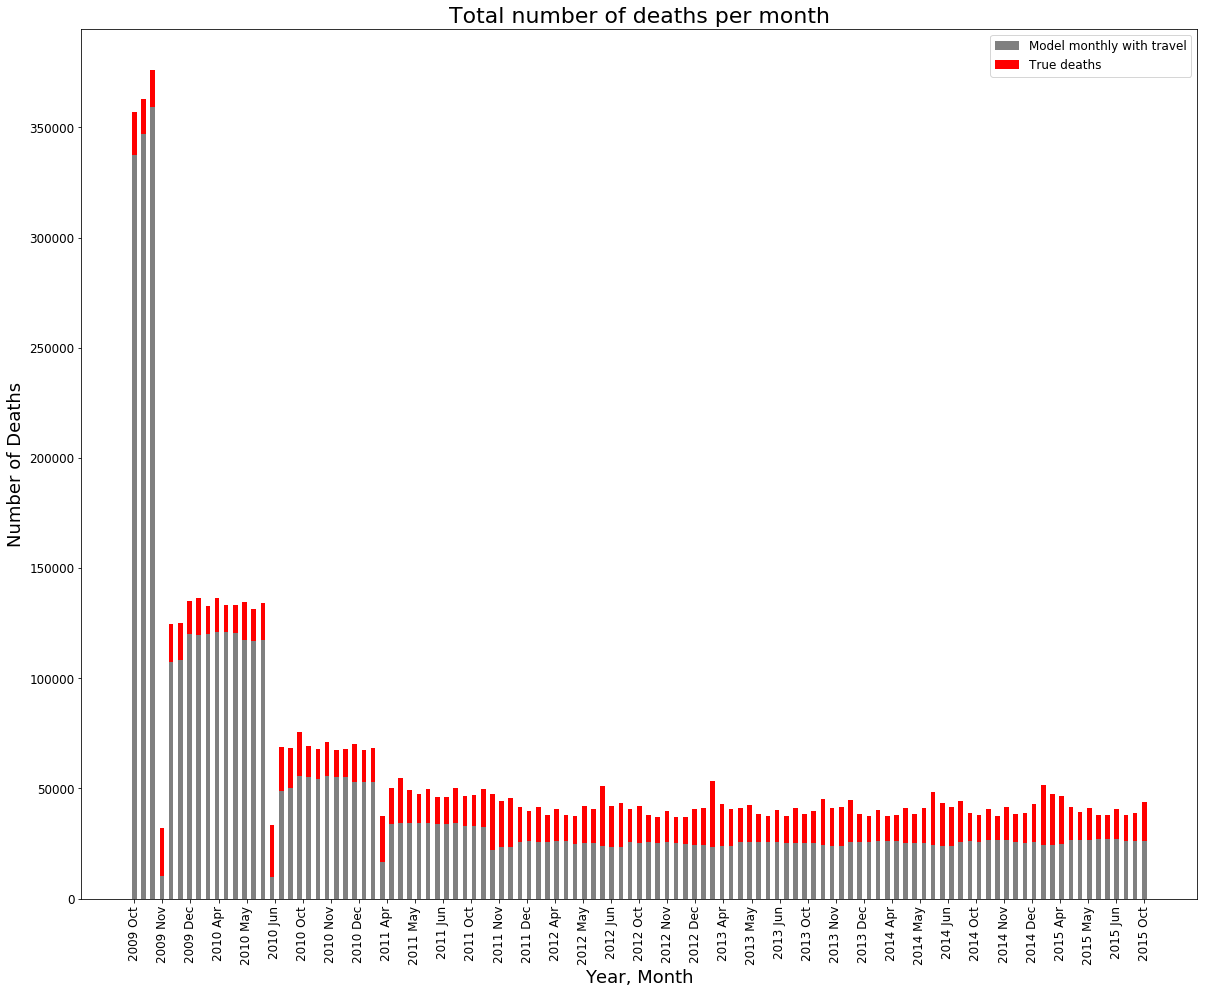

In [16]:
plt.figure(figsize=[20,16])
ind = np.arange(9*12+3)
width = 0.5
# p1 = plt.bar(ind, deaths_monthly['total_deaths'], width,
#              bottom=deaths_monthly['total_deaths'], color='grey')
p2 = plt.bar(ind, deaths_monthly['total_deaths'], width, color='grey')
#              bottom=menMeans, yerr=womenStd)
p3 = plt.bar(ind, grouped['DeathsFromPneumoniaAndInfluenza'][:-3], width,
             bottom=deaths_monthly['total_deaths'], color='red')

plt.xticks(np.linspace(0,110, 37),
           ('2009 Oct', '2009 Nov', '2009 Dec',
            #'2010 Jan', '2010 Feb', '2010 Mar',
            '2010 Apr', '2010 May', '2010 Jun',
            #'2010 Jul', '2010 Aug', '2010 Sep',
            '2010 Oct', '2010 Nov', '2010 Dec',
            #'2011 Jan', '2011 Feb', '2011 Mar',
            '2011 Apr', '2011 May', '2011 Jun',
            #'2011 Jul', '2011 Aug', '2011 Sep',
            '2011 Oct', '2011 Nov', '2011 Dec',
            #'2012 Jan', '2012 Feb', '2012 Mar',
            '2012 Apr', '2012 May', '2012 Jun',
            #'2012 Jul', '2012 Aug', '2012 Sep',
            '2012 Oct', '2012 Nov', '2012 Dec',
            #'2013 Jan', '2013 Feb', '2013 Mar',
            '2013 Apr', '2013 May', '2013 Jun',
            #'2013 Jul', '2013 Aug', '2013 Sep',
            '2013 Oct', '2013 Nov', '2013 Dec',
            #'2014 Jan', '2014 Feb', '2014 Mar',
            '2014 Apr', '2014 May', '2014 Jun',
            #'2014 Jul', '2014 Aug', '2014 Sep',
            '2014 Oct', '2014 Nov', '2014 Dec',
            #'2015 Jan', '2015 Feb', '2015 Mar',
            '2015 Apr', '2015 May', '2015 Jun',
            #'2015 Jul', '2015 Aug', '2015 Sep',
            '2015 Oct', '2015 Nov', '2015 Dec',
            #'2016 Jan', '2016 Feb', '2016 Mar',
            '2016 Apr', '2016 May', '2016 Jun',
            #'2016 Jul', '2016 Aug', '2016 Sep',
            '2016 Oct', '2016 Nov', '2016 Dec',
            #'2017 Jan', '2017 Feb', '2017 Mar',
            '2017 Apr', '2017 May', '2017 Jun',
            #'2017 Jul', '2017 Aug', '2017 Sep',
            '2017 Oct', '2017 Nov', '2017 Dec',
            #'2018 Jan', '2018 Feb', '2018 Mar',
            '2018 Apr', '2018 May', '2018 Jun',
            #'2018 Jul', '2018 Aug', '2018 Sep',
            '2018 Oct', '2018 Nov', '2018 Dec'
            ), rotation=90)
plt.legend((p2[0], p3[0]), ('Model monthly with travel', 'True deaths'), fontsize='12')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Year, Month", fontsize=18)
plt.ylabel("Number of Deaths", fontsize=18)
plt.title("Total number of deaths per month", fontsize=22)

In [21]:
deaths_monthly['total_deaths'].tolist() - grouped['DeathsFromPneumoniaAndInfluenza'][:-3]

Year  Month
2009  10       317459.0
      11       331259.0
      12       343055.0
2010  1        -11135.0
      2         90197.0
      3         91571.0
      4        105131.0
      5        102788.0
      6        107261.0
      7        105685.0
      8        109255.0
      9        107934.0
      10       100381.0
      11       102363.0
      12       100870.0
2011  1        -14427.0
      2         28657.0
      3         32037.0
      4         36366.0
      5         40760.0
      6         41003.0
      7         39969.0
      8         43105.0
      9         42910.0
      10        36294.0
      11        38428.0
      12        37561.0
2012  1         -4567.0
      2         17038.0
      3         13683.0
                 ...   
2016  7         11690.0
      8         14546.0
      9         14108.0
      10         9620.0
      11        11894.0
      12         9861.0
2017  1           -55.0
      2          4430.0
      3          6206.0
      4          7226.0
    

In [22]:
deaths_monthly['total_deaths']

1      337262
2      347121
3      359469
4       10395
5      107313
6      108363
7      120061
8      119717
9      120036
10     121108
11     121147
12     120620
13     117541
14     117002
15     117451
16       9613
17      48849
18      50240
19      55893
20      55126
21      54480
22      55490
23      55248
24      55314
25      53171
26      52938
27      52976
28      16561
29      33722
30      34283
        ...  
82      25976
83      25953
84      26117
85      25312
86      25149
87      25428
88      24255
89      24028
90      24006
91      25866
92      25989
93      25917
94      26443
95      26802
96      26649
97      25549
98      25346
99      25797
100     24408
101     24453
102     24664
103     26717
104     26795
105     26634
106     26966
107     27139
108     27140
109     26279
110     26366
111     26248
Name: total_deaths, Length: 111, dtype: int64

In [19]:
grouped['DeathsFromPneumoniaAndInfluenza'][:-3]

Year  Month
2009  10       19803.0
      11       15862.0
      12       16414.0
2010  1        21530.0
      2        17116.0
      3        16792.0
      4        14930.0
      5        16929.0
      6        12775.0
      7        15423.0
      8        11892.0
      9        12686.0
      10       17160.0
      11       14639.0
      12       16581.0
2011  1        24040.0
      2        20192.0
      3        18203.0
      4        19527.0
      5        14366.0
      6        13477.0
      7        15521.0
      8        12143.0
      9        12404.0
      10       16877.0
      11       14510.0
      12       15415.0
2012  1        21128.0
      2        16684.0
      3        20600.0
                ...   
2016  7        14286.0
      8        11407.0
      9        12009.0
      10       15692.0
      11       13255.0
      12       15567.0
2017  1        24310.0
      2        19598.0
      3        17800.0
      4        18640.0
      5        12677.0
      6        12192.0